There is ztf photometry available. Let's have a look.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
import matplotlib.gridspec as gridspec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
hdul = fits.open('ztf/ztflc3.fits')

In [3]:
hdul[1].data.names

['null_bitfield_flags',
 'oid',
 'expid',
 'hjd',
 'mjd',
 'mag',
 'magerr',
 'catflags',
 'filtercode',
 'ra',
 'dec',
 'chi',
 'sharp',
 'filefracday',
 'field',
 'ccdid',
 'qid',
 'limitmag',
 'magzp',
 'magzprms',
 'clrcoeff',
 'clrcounc',
 'exptime',
 'airmass',
 'programid']

In [4]:
#hdul[1].header

In [5]:
#catflags is the data qualiy.  32768 = cloud
data = hdul[1].data
data['catflags']

array([    0,     0,     0,     0, 32768,     0, 32768,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0, 32768,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0, 32768,     0,     0,     0,
           0,     0,     0,     0,     0,     0, 32768,     0, 32768,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0, 32768,     0, 32768,     0,     0,
           0,     0,     0,     0,     0,     0,     0, 32768, 32768,
           0, 32768,     0,     0,     0,     0, 32768, 65535,     0,
           0,     0,     0], dtype=int32)

In [6]:
dataq = data[data['catflags'] ==0]
gdata = dataq[dataq['filtercode'] == 'zg']
rdata = dataq[dataq['filtercode'] == 'zr']

(17.2, 17.9)

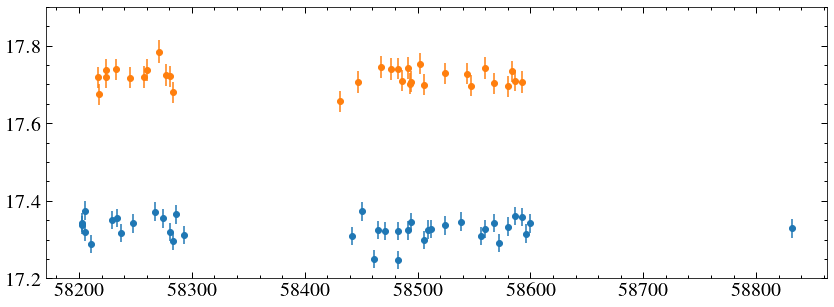

In [7]:
plt.errorbar(gdata['mjd'], gdata['mag'], yerr=gdata['magerr'], marker='o', ls='none')
plt.errorbar(rdata['mjd'], rdata['mag'], yerr=rdata['magerr'], marker='o', ls='none')
plt.ylim(17.2, 17.9)

In [8]:
period = 4.23*u.h

1.1420292201303253 h
1.662277113134937 h


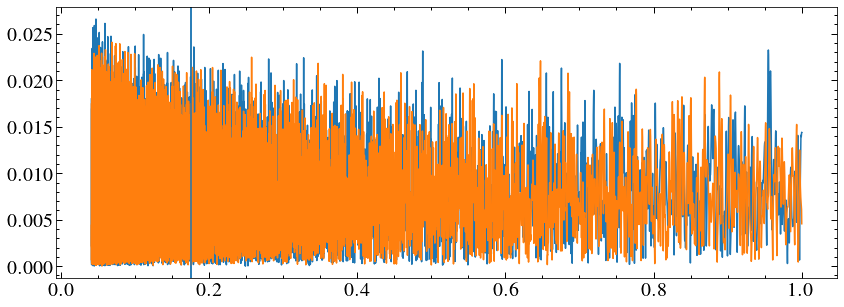

In [9]:
for band in [gdata, rdata]:
    lc = lk.LightCurve(time= band['mjd']*u.d, flux=band['mag'], flux_err=band['magerr'])
    lcfold = lc.fold(period)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=1*u.h, maximum_period=1*u.day)
    plt.plot(pg.period, pg.power)
    print(pg.period_at_max_power.to(u.h))
    plt.axvline(4.23/24)    

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

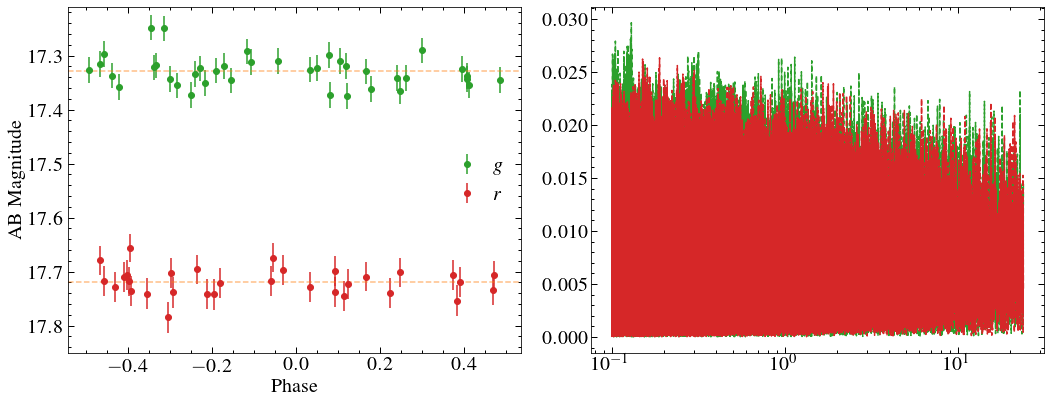

In [10]:
plt.figure(figsize=(15,6))
bands = ['$g$', '$r$']
cols = ['C2', 'C3']
for i, bandat in enumerate([gdata, rdata]):
    plt.subplot(121)
    lc = lk.LightCurve(time= bandat['mjd']*u.d, flux=bandat['mag'], flux_err=bandat['magerr'])
    lcfold = lc.fold(period)
    if i == 0:
        glc = lc
        glcf = lcfold
    if i == 1:
        rlc = lc
        rlcf = lcfold
    plt.errorbar(lcfold.time, lcfold.flux, yerr=lcfold.flux_err, marker='o', ls='none', label= bands[i], color=cols[i])
    plt.axhline(np.median(lc.flux), ls='--', c='C1', alpha=0.5)
    plt.subplot(122)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.1*u.h, maximum_period=1*u.day)
    plt.plot(pg.period*24, pg.power, ls='--', c=cols[i])
    
plt.subplot(121)    
plt.ylim(17.85, 17.21)
plt.xlabel('Phase')
plt.ylabel('AB Magnitude')
plt.legend()
plt.subplot(122)
plt.xscale('log')
#plt.yscale('log')
#[plt.axvline(line, ls='--') for line in [-0.03, 0.03]]
plt.tight_layout()
#plt.savefig('plots/ztf_folded.pdf')

In [25]:
#ecclipse duration
P = period
a = 0.7*u.Rsun
R1 = 0.0131*u.Rsun
R2 = 0.11*u.Rsun

tdur = P*(2*R1+2*R2)/(2*np.pi*a)
print(tdur.value*60)

14.206979636950306


In [27]:
phase_diff = tdur/period
print(phase_diff)
print(np.max(np.diff(glcf.time)))
print(np.max(np.diff(rlcf.time)))

0.05597706712746377
0.09402910165408684
0.12672654846392106


13.325992574349597

Is there a colour change?

In [14]:
print(len(glcf.time), len(rlcf.time))

39 32


In [15]:
from craftroom import resample

<ErrorbarContainer object of 3 artists>

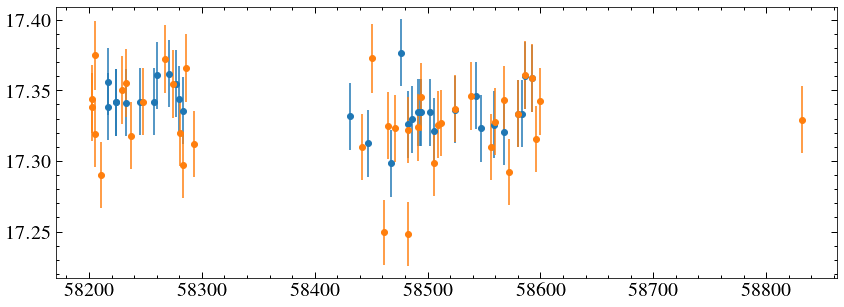

In [16]:
fakegt, fakegf = resample.bintogrid(glc.time, glc.flux, newx=rlc.time)
fakege = np.full(len(fakegt), np.mean(glc.flux_err))
plt.errorbar(fakegt, fakegf, yerr=fakege, marker='o', ls='none')
plt.errorbar(glc.time, glc.flux, yerr=glc.flux_err, marker='o', ls='none')

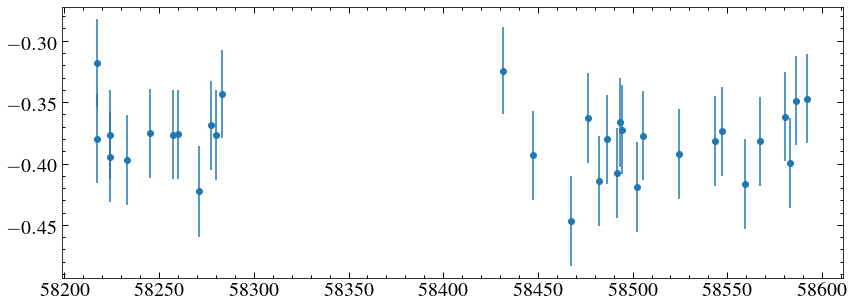

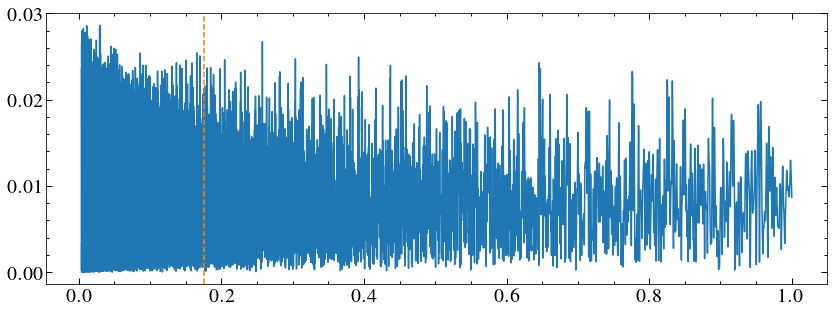

In [17]:
gminusr = fakegf - rlc.flux
gminusr_e = (fakege**2+rlc.flux_err**2)**0.5
plt.errorbar(fakegt, gminusr, yerr=gminusr_e, marker='o', ls='none')
plt.show()
grlc = lk.LightCurve(fakegt[:-1], gminusr[:-1], gminusr_e[:-1])
grpg = grlc.to_periodogram(oversample_factor=10,minimum_period=0.1*u.h, maximum_period=1*u.day)
plt.plot(grpg.period, grpg.power)
plt.axvline(period.to(u.d).value, c='C1', ls='--')

In [18]:
period

<Quantity 4.23 h>